# Build Recommendation System (sklearn)

In `B1_preprocess.ipynb`, I have distilled several features from raw data, which I will now utilize for song recommendations. Due to downsampling, these features are small enough to fit onto RAM / a single disk. Therefore it is
possible to come up with user-music ratings using single-machine toolkits, e.g. Pandas. That's what I am going to do now.

As a reminder, I first retained only the last 30 days of data. Then for each (`uid, song_id`) pair, I computed the following features:
- `p_count`, the total number of plays, during these 30 days
- `d_count`, the total number of downloads, ditto
- `ps_ratio`, the **mean** ratio of play_time and song_length, ditto

In other words, the user-music ratings are *implicit*, in the sense that they are not explicit, deliberate ratings of preference provided by users.

## Design Strategy

### Computing the Implicit Rating
The formula we will use is: `rating` = Log10{ 0.4 (`ps_ratio` $\times$ `p_count`) + 0.6 `d_count` }.

In other words, a weighted average. I am giving `d_count` a higher weight, assuming that users must be really interested for them to bother downloading songs. Also, I am weighting `p_count` with `ps_ratio`, because an incomplete play (probably) reflects a lower level of interest.

Last but not least, the log10 serves to compress the scale of `rating`.

### Algorithm for Making Recommendations
- Spark ALS via Google Cloud Platform. This is the only practical choice; after experimenting I concluded that there simply isn't enough RAM on my 2015 MBP.

## Load and examine data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix, csr_matrix

np.random.seed(10)

plt.style.use('ggplot')

In [2]:
rec_features = pd.read_csv("../data/rec/rec_features.csv")

In [3]:
# Examine data
rec_features.head(5)

,uid,song_id,p_count,d_count,ps_ratio
0,12333,15249349,1,0,0.746504
1,1164092,4594934,1,0,0.380673
2,1863042,4090645,2,0,0.902413
3,1863042,7048351,1,0,1.000000
4,3629720,4681151,1,0,0.996810


In [4]:
# Examine number of rows; make sure no NAs
rec_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777079 entries, 0 to 1777078
Data columns (total 5 columns):
uid         int64
song_id     int64
p_count     int64
d_count     int64
ps_ratio    float64
dtypes: float64(1), int64(4)
memory usage: 67.8 MB


In [5]:
# Examine distribution of each feature
rec_features.describe()

,uid,song_id,p_count,d_count,ps_ratio
count,1.777079e+06,1.777079e+06,1.777079e+06,1.777079e+06,1.777079e+06
mean,1.664832e+08,6.150307e+06,3.179120e+00,8.035602e-02,6.560078e-01
std,1.419348e+07,1.249561e+07,1.060321e+01,3.016566e-01,3.637047e-01
min,1.233300e+04,-1.000000e+00,1.000000e+00,0.000000e+00,2.100840e-04
25%,1.679312e+08,7.085280e+05,1.000000e+00,0.000000e+00,3.262397e-01
50%,1.683125e+08,4.278162e+06,1.000000e+00,0.000000e+00,7.995213e-01
75%,1.686806e+08,6.989211e+06,3.000000e+00,0.000000e+00,9.970958e-01
max,1.692516e+08,2.147484e+09,1.709000e+03,1.300000e+01,1.000000e+00


In [6]:
# Calculate utility score
rec_features['rating'] = (0.6*rec_features["d_count"] \
                         + 0.4*rec_features["p_count"]*rec_features["ps_ratio"])

In [18]:
rec_features['rating'].describe()

count    1.777079e+06
mean     9.929816e-01
std      3.475023e+00
min      8.403361e-05
25%      1.865369e-01
50%      4.000000e-01
75%      8.000000e-01
max      6.532739e+02
Name: rating, dtype: float64

Text(0.5, 1.0, 'Implicit Rating Distribution')

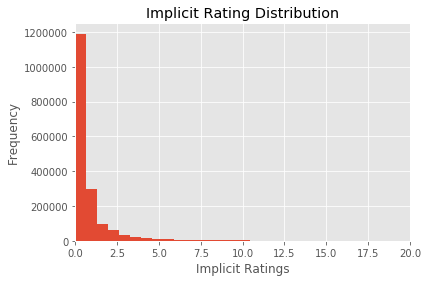

In [7]:
# Plot distribution of utility score
# Can see that without compression by log10, the rating would spread over two orders of magnitude

rec_features['rating'].plot.hist(bins=1000)
plt.xlim([0,20])
plt.xlabel("Implicit Ratings")
plt.title("Implicit Rating Distribution")

## Avoid cold-starters; filter `uid`
Collaborative filtering becomes unreliable for user who have only a few recorded events --- the so-called 'cold start' problem. Here we filter out users who have interacted with **less than 5 songs**. For those who are filtered out, a content-based recommendation system would be more suitable. 

But that's outside the scope of this project, because I'm barely given any song metadata!

In [8]:
# First count number of observations under each user
cold_starters = rec_features.groupby('uid').rating.agg(['count']).rename(columns={'count': 'count_by_uid'})
print(f"Number of distinct uid's: {len(cold_starters.index)}")

# Extract uids that have less than 5 observations
cold_starters = cold_starters.index[ cold_starters.count_by_uid < 5 ]
print(f"Number of cold-starter uid's: {len(cold_starters)}")

Number of distinct uid's: 36158
Number of cold-starter uid's: 7687


In [9]:
rec_features.shape

(1777079, 6)

In [10]:
# Set uid to index and filter by index
rec_features_warm = rec_features.set_index('uid')

rec_features_warm = rec_features_warm.drop(index = cold_starters)
rec_features_warm = rec_features_warm.reset_index()

In [11]:
rec_features_warm.shape

(1761345, 6)

## Prepare for upload to cloud service
Despite the downsampling, it is still impossible to decompose the utility matrix on my laptop. Therefore, I am invoking the power of Google Cloud Platform (GCP). Fortunately, Spark ALS on GCP does not require explicit construction of an utility matrix; instead, it takes the following three columns --- e.g. from an SQL DB --- and handles the rest.

`user_id, item_id, rating`.

In [12]:
upload = rec_features_warm.loc[:, ["uid", 'song_id', "rating"]]
upload.to_csv("../data/rec/upload.csv", index=False, header=False)

In [13]:
upload.rating.describe()

count    1.761345e+06
mean     9.849781e-01
std      3.318444e+00
min      8.403361e-05
25%      1.847460e-01
50%      4.000000e-01
75%      8.000000e-01
max      5.920201e+02
Name: rating, dtype: float64

#### Downsample for Testing Spark ALS

In [14]:
# Randomly choose 10 users and retain only their data
chosen_ones = np.random.choice(upload.uid, replace=False, size=10)

In [15]:
upload_small = upload.loc[ upload['uid'].isin(chosen_ones), : ]

In [16]:
upload_small.head(5)

,uid,song_id,rating
1290,167778904,896522,0.397186
1291,167778904,900839,0.400000
1292,167778904,3418611,0.400000
2216,167934381,324240,0.217088
2217,167934381,448491,0.743365


In [17]:
upload_small.to_csv('../data/rec/rec_test.csv', index=False)